# Second order stochastic methods for CryoEM -- OASIS

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [95]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  74.04 sec.


In [4]:
# Extract two subsets with fixed seed key so that we always get the same splitting.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

split_seed = 60
split_key = random.PRNGKey(split_seed)
idxrand = random.permutation(split_key, N0)

idx1full = idxrand[:N0//2]
idx2full = idxrand[N0//2:]

print(split_key)
print(idx1full[:10])
print(idx2full[:10])

[ 0 60]
[ 18720  60093  53249 102196  43608  18973  24325  65695  39526  50914]
[34047 56252 41587 49412 94583 65918 60383 22109 83727 10584]


In [5]:
out_dir = out_dir = '../data/out_dev/'

nx_crop = 64 # 64 #8 #192 # 128 # 64
N = 10000 #10000 #200 #104000 #80000 # 20000

idx1 = idx1full[:N]
idx2 = idx2full[:N]

In [ ]:
processed_data1 = preprocess(imgs0, params0, nx_crop = nx_crop, idx = idx1)

imgs_f1 = processed_data1["imgs_f"]
angles1 = processed_data1["angles"]
shifts1 = processed_data1["shifts"]
ctf_params1 = processed_data1["ctf_params"]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
N0 = 105519
idx provided
N = 10000
Taking FFT of the images:
Batch 1/10  2.87 sec.
Batch 2/10  2.77 sec.
Batch 3/10  2.77 sec.
Batch 4/10  2.76 sec.
Batch 5/10  2.77 sec.
Batch 6/10  2.77 sec.
Batch 7/10  2.80 sec.
Batch 8/10 

In [ ]:
processed_data2 = preprocess(imgs0, params0, nx_crop = nx_crop, idx = idx2)

imgs_f2 = processed_data2["imgs_f"]
angles2 = processed_data2["angles"]
shifts2 = processed_data2["shifts"]
ctf_params2 = processed_data2["ctf_params"]

In [11]:
# Assuming these variables are the same for all images in both sets

pixel_size = processed_data1["pixel_size"]
nx = processed_data1["nx"]
mask = processed_data1["mask"]
sigma_noise = processed_data1["sigma_noise"]
x_grid = processed_data1["x_grid"]
N = imgs_f1.shape[0]

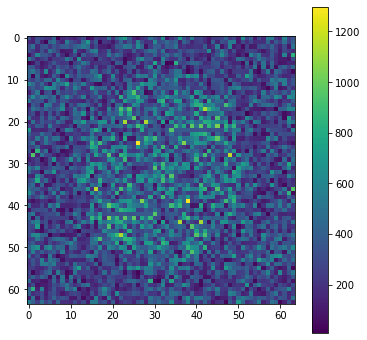

In [12]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f1[15].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [13]:
#del(imgs0)

### Only volume reconstruction for now - SGD vs OASIS

In [14]:
# Apply mask to images

apply_mask = True

if apply_mask:
    mask2d = mask[0].reshape(-1)
    imgs_f1 = imgs_f1 * mask2d
    imgs_f2 = imgs_f2 * mask2d
else:
    mask = jnp.ones(mask.shape)

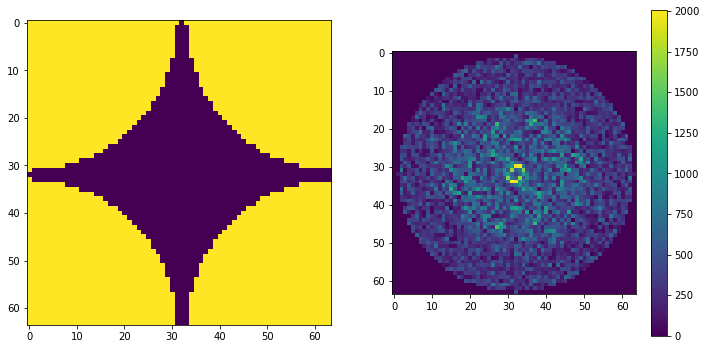

In [15]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(mask[0])

plt.subplot(1,2,2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f1[123].reshape([nx_crop,nx_crop]))));plt.colorbar()

plt.rcParams["figure.figsize"]=6,6


In [16]:
alpha =  1e-9 #1e-5 #1e-9 #1e-9 # 1e-5
interp_method = "nn"

slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

Use the same datasets, loss, grad, hvp, x0, D0 for SGD, OASIS (and CG)

In [17]:
grad_func1, loss_func1, hvp_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles1, shifts1, ctf_params1, imgs_f1, sigma_noise)
grad_func2, loss_func2, hvp_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles2, shifts2, ctf_params2, imgs_f2, sigma_noise)

In [18]:
n_epochs = 3 #2000 * 4 
batch_sz = 100
n_batch = N // batch_sz

zD01z = np.zeros([nx,nx,nx])
zD02z = np.zeros([nx,nx,nx])

#zD01z = [] 
#zD02z = [] 


key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

for i in tqdm(range(n_epochs)):
    key, subkey = random.split(key)
    idx_batches = np.array_split(random.permutation(subkey, N), n_batch)
        
    for idx in idx_batches:
        key, subkey = random.split(key)

        z = random.rademacher(subkey, [nx,nx,nx], dtype=x0.dtype)

        zD01z += z * hvp_func1(x0, z, np.array(idx))
        zD02z += z * hvp_func2(x0, z, np.array(idx))

        # Any more memory efficient way of doing this? The kernel dies :(
        
        # For some reason, passing idx without np.array doesn't work (it is
        # considered to be tuple
        #zD01z.append(z * hvp_func1(x0, z, np.array(idx)))
        #zD02z.append(z * hvp_func2(x0, z, np.array(idx)))

zD01z = np.array(zD01z)
zD02z = np.array(zD02z)        
        
#D01 = np.mean(zD01z, axis = 0)
#D02 = np.mean(zD02z, axis = 0)

D01 = zD01z / (n_epochs * n_batch)
D02 = zD02z / (n_epochs * n_batch)

100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


In [19]:
# Compute the sums term by term to have an idea of convergence
compute_separate_terms = False

if compute_separate_terms:
    D01est = [zD01z[0]]
    D02est = [zD02z[0]]
    for i in tqdm(range(1, len(zD01z))):
        D01est.append(D01est[-1] + zD01z[i])
        D02est.append(D02est[-1] + zD02z[i])

        #D01est[i] = D01est[i] / (i+1)
        #D02est[i] = D02est[i] / (i+1)

    D01est = np.array([ Di / (i+1) for i, Di in enumerate(D01est)])
    D02est = np.array([ Di / (i+1) for i, Di in enumerate(D02est)])

In [20]:
if compute_separate_terms:
    D01norm = []
    D02norm = []
    for i in tqdm(range(len(D01est))):
        D01norm.append(jnp.linalg.norm(D01est[i].reshape(-1), 2))
        D02norm.append(jnp.linalg.norm(D02est[i].reshape(-1), 2))

In [21]:
if compute_separate_terms:
    assert(jnp.max(jnp.abs(D01est[-1] - D01)) == 0)
    assert(jnp.max(jnp.abs(D02est[-1] - D02)) == 0)

1.0000000000000023e-09
0.07571895202677324
75718952.02677307


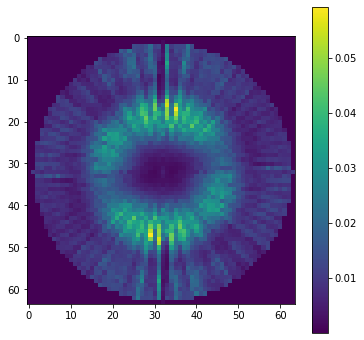

In [22]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D01))/jnp.min(jnp.abs(D01)))

In [23]:
print(jnp.max(jnp.abs(D01)))
print(jnp.max(jnp.abs(D02))) 
print(jnp.max(jnp.abs(D01-D02)))

0.07571895202677324
0.07687775972349578
0.010267614384906386


In [24]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) - do it in batches

batch_sz = 10
n_batch = N // batch_sz
idx_batches = np.array_split(np.arange(N), n_batch)
ones = jnp.ones(x0.shape, dtype=jnp.complex128)

D1 = np.zeros([nx,nx,nx], dtype=np.complex128)
D2 = np.zeros([nx,nx,nx], dtype=np.complex128)
for idx in idx_batches:
    D1 += hvp_func1(x0, ones, idx)
    D2 += hvp_func2(x0, ones, idx)    
    
D1 = jnp.array(D1/n_batch)
D2 = jnp.array(D2/n_batch)


9.999999999999934e-10
0.07571895202677284
75718952.02677333


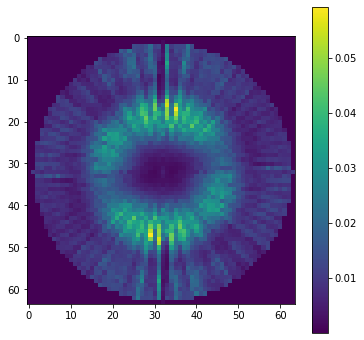

In [25]:
plt.imshow(jnp.fft.fftshift(jnp.abs(D01[0,:,:]))); plt.colorbar()
print(jnp.min(jnp.abs(D1)))
print(jnp.max(jnp.abs(D1)))
print(jnp.max(jnp.abs(D1))/jnp.min(jnp.abs(D1)))

In [26]:
err1 = jnp.max(jnp.abs(D1-D01)/jnp.max(jnp.abs(D1)))
print(f"Error D1 = {err1}")

err2 = jnp.max(jnp.abs(D2-D02)/jnp.max(jnp.abs(D2)))
print(f"Error D2 = {err2}")

Error D1 = 1.2463056971884563e-14
Error D2 = 1.2816748889155426e-14


In [27]:
jnp.max(jnp.abs(D2))

DeviceArray(0.07687776, dtype=float64)

In [28]:
if compute_separate_terms:
    err1 = [ jnp.max(jnp.abs(D1 - Di))/jnp.max(jnp.abs(D1)) for Di in D01est ]
    err2 = [ jnp.max(jnp.abs(D2 - Di))/jnp.max(jnp.abs(D2)) for Di in D02est ]

    #err1 = [ jnp.max(jnp.abs(D1 - Di)) for Di in D01est ]
    #err2 = [ jnp.max(jnp.abs(D2 - Di)) for Di in D02est ]
    
    plt.subplot(1,2,1)
    plt.semilogy(err1)
    
    plt.subplot(1,2,2)
    errr = jnp.abs(jnp.array(D01norm))
    plt.semilogy(errr)

#### Sanity check that the Hessian is indeed diagonal for NN interpolation and that I'm computing it correctly

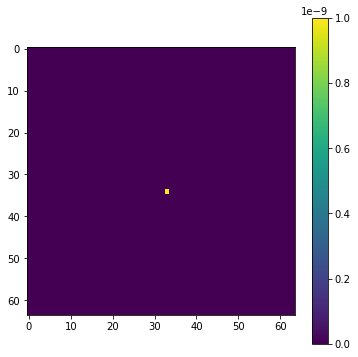

In [29]:
ei = jnp.zeros([nx,nx,nx], dtype = jnp.complex128)
ei = ei.at[0,2,1].set(1)
hvp = hvp_func1(x0, ei, np.array([23, 1, 0, 6]))
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp[0,:,:]))); plt.colorbar()

In [30]:
if interp_method == "nn":
    print("Checking")
    assert(jnp.abs(hvp[0,2,1] - jnp.sum(hvp)) == 0)

Checking


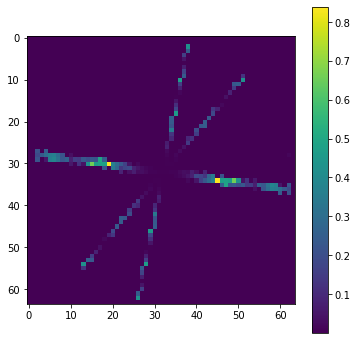

In [31]:
ones = jnp.ones(x0.shape, dtype=jnp.complex128)
hvp_diag = hvp_func1(x0, ones, np.array([23, 1, 0, 6]))
plt.imshow(jnp.fft.fftshift(jnp.abs(hvp_diag[0,:,:]))); plt.colorbar()

In [32]:
if interp_method == "nn":
    print("Checking")
    assert(jnp.abs(hvp[0,2,1] - hvp_diag[0,2,1]) == 0)

Checking


### Compute full Hessian (only for small operators)

In [33]:
compute_full_hessian = False

In [34]:
if compute_full_hessian:
    print("Computing Hessian...", end="")
    H1 = jax.hessian(lambda x : loss_func1(x, np.arange(10)))(jnp.real(x0))
    print("done.")
    H1 = H1.reshape([nx**3, nx**3])
    
    print("Computing Hessian inverse...", end="")
    H1inv = jnp.linalg.inv(H1)
    print("done.")

    

In [35]:
#plt.spy(H1)

In [36]:
#plt.spy(H1inv)

In [37]:
#H1log = jnp.log(H1)
#H1log = jnp.abs(H1log.at[H1log == -jnp.inf].set(0))

#H1log = H1log.at[H1log == jnp.inf].set(0)
#plt.spy(H1log)

In [38]:
#plt.spy(H1log)

In [39]:
#H1log[0]

In [40]:
if compute_full_hessian:
    plt.rcParams["figure.figsize"]=24,24

    plt.imshow((jnp.abs(H1inv)))
    plt.colorbar()

In [41]:
if compute_full_hessian:
    plt.imshow((H1[:nx*3,:nx*3])); plt.colorbar()


In [42]:
if compute_full_hessian:

    plt.rcParams["figure.figsize"]=12,12

    plt.imshow((H1log[nx**2:2*nx**2,nx**2:2*nx**2])); plt.colorbar()

    plt.rcParams["figure.figsize"]=6,6

In [43]:
if compute_full_hessian:
    plt.rcParams["figure.figsize"]=12,12

    plt.imshow((H1log[:2*nx , :nx*2])); plt.colorbar()
    #plt.imshow((H1ki)); #plt.colorbar()

    plt.rcParams["figure.figsize"]=6,6

In [184]:
#plt.plot(H11[78,13300:13400])

In [45]:
#H11[78,13300:13400]

### Inititial points

In [46]:
# Use a fixed seed and the same size (e.g. 320) every time we generate x01 and x02
# and only then crop to the intended size, to ensure that we always generate the same starting 
# points no matter the dimensions.

key = random.PRNGKey(64)
key, subkey1, subkey2 = random.split(key, 3)

x01 = random.normal(subkey1, [320,320,320], dtype = jnp.complex128)
x02 = random.normal(subkey2, [320,320,320], dtype = jnp.complex128)

x01 = x01[:nx, :nx, :nx]
x02 = x02[:nx, :nx, :nx]

print(x01[:2,:2,:2])
print(x02[:2,:2,:2])

[[[-1.27572166+0.21509077j -0.2528686 +0.84470363j]
  [-0.38843287+0.83380408j  0.50352958-0.57816483j]]

 [[-0.11351889+0.51268045j  0.23619305+0.17658612j]
  [ 0.71392439-0.76703503j  0.75787928-1.24197719j]]]
[[[ 0.93771135+1.14874736j -0.97207431+0.34850555j]
  [-0.97416572-0.71793741j -0.83088213+0.69339065j]]

 [[ 0.03868287+0.27724299j -1.25742005+0.03433057j]
  [-0.11024288-0.26589985j -1.75752847-0.23352432j]]]


#### SGD

In [381]:
N_epochs = 20
batch_size = 1000
step_size = 100 #1e-1 # 1e1 #1e1 #1e1 #1e1 #1e-4 #1e-1 #1e-5 #1e-2 #1000000 # 1e-3

# Step sizes (empirically found, i.e. the largest that doesn't lead to loss exploding): 

#### Tri interpolation, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#  no precon: 1e1
#  precon: 1e-1 (with D1, D2 computed as for NN -- similar to OASIS)


### NN interpolation, lam=1e-9

# 10k imgs, 64px:
#   no precon: 1e1
#   precon: 1e-1

# 40k imgs, 128px:
#   no precon: 1e0
#   precon: 1e-2


### NN interpolation, lam=1e-12

# 40k imgs, 128px:
#   no precon: 1e1
#   precon: 

# 52k imgs, 192px:
#   no precon: 1e0
#   precon: 

In [382]:
P1 = None
#P1 = 1/D01

t0 = time.time()

#v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N, x01, step_size, N_epochs, batch_size, P = P1, verbose=True, iter_display=1)

v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, N, x01, step_size, N_epochs, batch_size, P = P1, adaptive_step_size = True, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/20 

100%|██████████| 10/10 [00:03<00:00,  3.21it/s, grad=1.852e+01, loss=3.141e+08]


  |Grad| = 1.999e+01
  Loss = 3.150e+08
  alpha = 6.25
Epoch 2/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.413e+01, loss=3.150e+08]


  |Grad| = 1.550e+01
  Loss = 3.131e+08
  alpha = 6.25
Epoch 3/20 

100%|██████████| 10/10 [00:02<00:00,  3.69it/s, grad=1.591e+01, loss=3.116e+08]


  |Grad| = 1.340e+01
  Loss = 3.123e+08
  alpha = 6.25
Epoch 4/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.366e+01, loss=3.107e+08]


  |Grad| = 1.332e+01
  Loss = 3.118e+08
  alpha = 6.25
Epoch 5/20 

100%|██████████| 10/10 [00:02<00:00,  3.70it/s, grad=1.176e+01, loss=3.125e+08]


  |Grad| = 1.313e+01
  Loss = 3.115e+08
  alpha = 6.25
Epoch 6/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.247e+01, loss=3.109e+08]


  |Grad| = 1.295e+01
  Loss = 3.113e+08
  alpha = 6.25
Epoch 7/20 

100%|██████████| 10/10 [00:02<00:00,  3.65it/s, grad=1.226e+01, loss=3.102e+08]


  |Grad| = 1.247e+01
  Loss = 3.111e+08
  alpha = 6.25
Epoch 8/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.192e+01, loss=3.108e+08]


  |Grad| = 1.303e+01
  Loss = 3.110e+08
  alpha = 6.25
Epoch 9/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.186e+01, loss=3.090e+08]


  |Grad| = 1.270e+01
  Loss = 3.109e+08
  alpha = 6.25
Epoch 10/20 

100%|██████████| 10/10 [00:02<00:00,  3.67it/s, grad=1.385e+01, loss=3.084e+08]


  |Grad| = 1.260e+01
  Loss = 3.109e+08
  alpha = 6.25
Epoch 11/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.295e+01, loss=3.078e+08]


  |Grad| = 1.282e+01
  Loss = 3.109e+08
  alpha = 6.25
Epoch 12/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.258e+01, loss=3.089e+08]


  |Grad| = 1.257e+01
  Loss = 3.108e+08
  alpha = 6.25
Epoch 13/20 

100%|██████████| 10/10 [00:02<00:00,  3.69it/s, grad=1.624e+01, loss=3.091e+08]


  |Grad| = 1.314e+01
  Loss = 3.108e+08
  alpha = 6.25
Epoch 14/20 

100%|██████████| 10/10 [00:02<00:00,  3.67it/s, grad=1.229e+01, loss=3.067e+08]


  |Grad| = 1.240e+01
  Loss = 3.108e+08
  alpha = 6.25
Epoch 15/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.252e+01, loss=3.115e+08]


  |Grad| = 1.234e+01
  Loss = 3.108e+08
  alpha = 6.25
Epoch 16/20 

100%|██████████| 10/10 [00:02<00:00,  3.67it/s, grad=1.153e+01, loss=3.106e+08]


  |Grad| = 1.298e+01
  Loss = 3.108e+08
  alpha = 6.25
Epoch 17/20 

100%|██████████| 10/10 [00:02<00:00,  3.69it/s, grad=1.181e+01, loss=3.129e+08]


  |Grad| = 1.297e+01
  Loss = 3.107e+08
  alpha = 6.25
Epoch 18/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.387e+01, loss=3.095e+08]


  |Grad| = 1.299e+01
  Loss = 3.107e+08
  alpha = 6.25
Epoch 19/20 

100%|██████████| 10/10 [00:02<00:00,  3.64it/s, grad=1.183e+01, loss=3.079e+08]


  |Grad| = 1.363e+01
  Loss = 3.107e+08
  alpha = 6.25
Epoch 20/20 

100%|██████████| 10/10 [00:02<00:00,  3.63it/s, grad=1.263e+01, loss=3.062e+08]


  |Grad| = 1.286e+01
  Loss = 3.107e+08
  alpha = 6.25
Total time:  72.19 seconds


In [383]:
P2 = None
#P2 = 1/D02

t0 = time.time()

#v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N, x02, step_size, N_epochs, batch_size, P = P2, verbose=True, iter_display=1)
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, N, x02, step_size, N_epochs, batch_size, P = P2, adaptive_step_size = True, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/20 

100%|██████████| 10/10 [00:03<00:00,  3.19it/s, grad=1.758e+01, loss=3.142e+08]


  |Grad| = 1.961e+01
  Loss = 3.146e+08
  alpha = 6.25
Epoch 2/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.400e+01, loss=3.133e+08]


  |Grad| = 1.544e+01
  Loss = 3.127e+08
  alpha = 6.25
Epoch 3/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.259e+01, loss=3.109e+08]


  |Grad| = 1.329e+01
  Loss = 3.119e+08
  alpha = 6.25
Epoch 4/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.202e+01, loss=3.075e+08]


  |Grad| = 1.297e+01
  Loss = 3.114e+08
  alpha = 6.25
Epoch 5/20 

100%|██████████| 10/10 [00:02<00:00,  3.67it/s, grad=1.203e+01, loss=3.080e+08]


  |Grad| = 1.209e+01
  Loss = 3.111e+08
  alpha = 6.25
Epoch 6/20 

100%|██████████| 10/10 [00:02<00:00,  3.67it/s, grad=1.133e+01, loss=3.127e+08]


  |Grad| = 1.233e+01
  Loss = 3.109e+08
  alpha = 6.25
Epoch 7/20 

100%|██████████| 10/10 [00:02<00:00,  3.70it/s, grad=1.276e+01, loss=3.092e+08]


  |Grad| = 1.346e+01
  Loss = 3.107e+08
  alpha = 6.25
Epoch 8/20 

100%|██████████| 10/10 [00:02<00:00,  3.64it/s, grad=1.165e+01, loss=3.073e+08]


  |Grad| = 1.244e+01
  Loss = 3.106e+08
  alpha = 6.25
Epoch 9/20 

100%|██████████| 10/10 [00:02<00:00,  3.69it/s, grad=1.847e+01, loss=3.056e+08]


  |Grad| = 1.335e+01
  Loss = 3.105e+08
  alpha = 6.25
Epoch 10/20 

100%|██████████| 10/10 [00:02<00:00,  3.64it/s, grad=1.218e+01, loss=3.072e+08]


  |Grad| = 1.226e+01
  Loss = 3.105e+08
  alpha = 6.25
Epoch 11/20 

100%|██████████| 10/10 [00:02<00:00,  3.65it/s, grad=1.309e+01, loss=3.120e+08]


  |Grad| = 1.216e+01
  Loss = 3.104e+08
  alpha = 6.25
Epoch 12/20 

100%|██████████| 10/10 [00:02<00:00,  3.70it/s, grad=1.254e+01, loss=3.070e+08]


  |Grad| = 1.221e+01
  Loss = 3.104e+08
  alpha = 6.25
Epoch 13/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.487e+01, loss=3.131e+08]


  |Grad| = 1.266e+01
  Loss = 3.104e+08
  alpha = 6.25
Epoch 14/20 

100%|██████████| 10/10 [00:02<00:00,  3.70it/s, grad=1.080e+01, loss=3.068e+08]


  |Grad| = 1.228e+01
  Loss = 3.103e+08
  alpha = 6.25
Epoch 15/20 

100%|██████████| 10/10 [00:02<00:00,  3.66it/s, grad=1.373e+01, loss=3.099e+08]


  |Grad| = 1.211e+01
  Loss = 3.103e+08
  alpha = 6.25
Epoch 16/20 

100%|██████████| 10/10 [00:02<00:00,  3.70it/s, grad=1.124e+01, loss=3.097e+08]


  |Grad| = 1.241e+01
  Loss = 3.103e+08
  alpha = 6.25
Epoch 17/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.200e+01, loss=3.115e+08]


  |Grad| = 1.323e+01
  Loss = 3.103e+08
  alpha = 6.25
Epoch 18/20 

100%|██████████| 10/10 [00:02<00:00,  3.64it/s, grad=1.346e+01, loss=3.049e+08]


  |Grad| = 1.306e+01
  Loss = 3.103e+08
  alpha = 6.25
Epoch 19/20 

100%|██████████| 10/10 [00:02<00:00,  3.69it/s, grad=1.345e+01, loss=3.119e+08]


  |Grad| = 1.293e+01
  Loss = 3.103e+08
  alpha = 6.25
Epoch 20/20 

100%|██████████| 10/10 [00:02<00:00,  3.68it/s, grad=1.129e+01, loss=3.085e+08]


  |Grad| = 1.266e+01
  Loss = 3.103e+08
  alpha = 6.25
Total time:  72.25 seconds


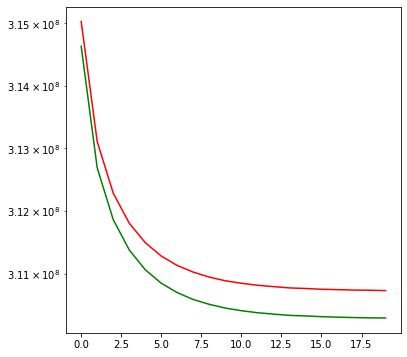

In [384]:
plt.semilogy(loss_rec1, 'r')
plt.semilogy(loss_rec2, 'g')

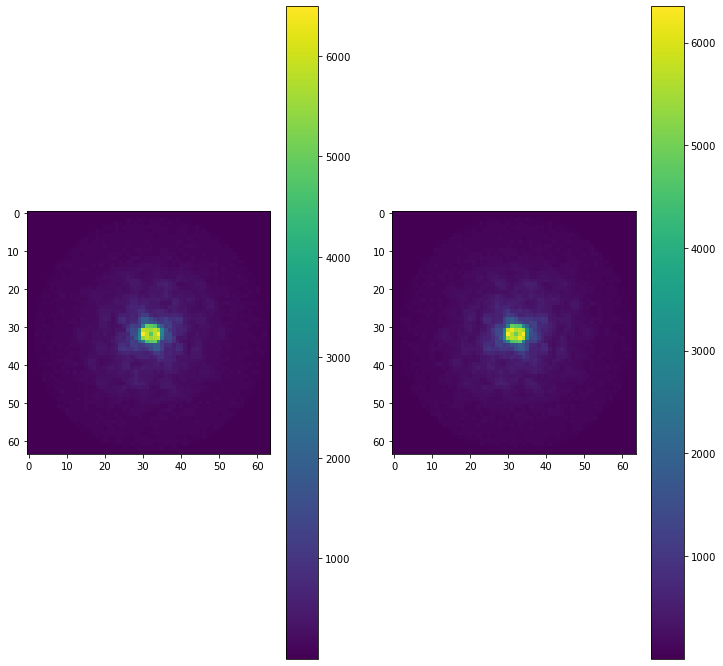

In [385]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); plt.colorbar()

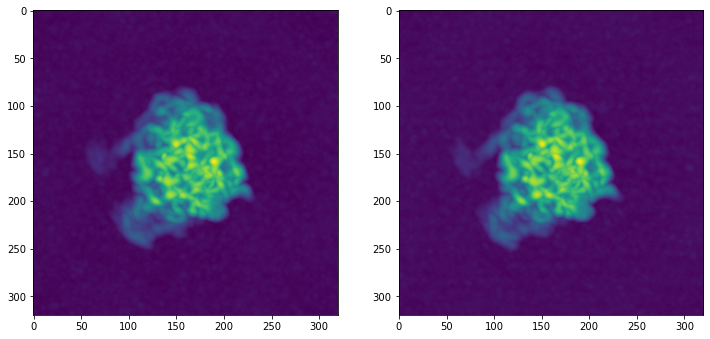

In [252]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [253]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

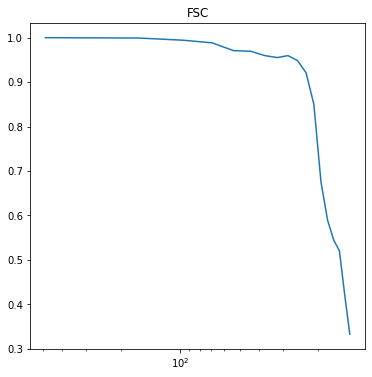

In [254]:
res, fsc_sgd, shell_points = calc_fsc(v_rec1, v_rec2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_sgd)
plt.gca().invert_xaxis()
plt.title("FSC")

In [55]:
print(fsc_sgd[21])
print(fsc_sgd[22])
print(res_angs[21])
print(res_angs[22])

0.3382274346056478
0.3382274346056478
13.830013305388063
13.830013305388063


In [56]:
print(fsc_sgd[28])
print(fsc_sgd[29])
print(res_angs[28])
print(res_angs[29])

0.3382274346056478
0.3382274346056478
13.830013305388063
13.830013305388063


### SGD preconditioned + adaptive

In [228]:
N_epochs = 20
batch_size = 1000
step_size = 100

In [237]:
#P1 = None
P1 = 1/D01

t0 = time.time()

v_ad_rec1, loss_ad_rec1, grad_ad_rec1 = sgd(grad_func1, loss_func1, N, x01, step_size, N_epochs, batch_size, P = P1, adaptive_step_size = True, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/20 

100%|██████████| 10/10 [00:03<00:00,  2.64it/s, grad=1.420e+01, loss=3.120e+08]


  |Grad| = 1.952e+01
  Loss = 3.130e+08
  alpha = 0.09765625
Epoch 2/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.252e+01, loss=3.109e+08]


  |Grad| = 1.320e+01
  Loss = 3.110e+08
  alpha = 0.09765625
Epoch 3/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.179e+01, loss=3.124e+08]


  |Grad| = 1.234e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 4/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.180e+01, loss=3.097e+08]


  |Grad| = 1.175e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 5/20 

100%|██████████| 10/10 [00:02<00:00,  3.56it/s, grad=1.135e+01, loss=3.092e+08]


  |Grad| = 1.240e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 6/20 

100%|██████████| 10/10 [00:02<00:00,  3.59it/s, grad=1.286e+01, loss=3.053e+08]


  |Grad| = 1.198e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 7/20 

100%|██████████| 10/10 [00:02<00:00,  3.59it/s, grad=1.367e+01, loss=3.110e+08]


  |Grad| = 1.140e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 8/20 

100%|██████████| 10/10 [00:02<00:00,  3.55it/s, grad=1.281e+01, loss=3.095e+08]


  |Grad| = 1.215e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 9/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.338e+01, loss=3.084e+08]


  |Grad| = 1.224e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 10/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.297e+01, loss=3.100e+08]


  |Grad| = 1.201e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 11/20 

100%|██████████| 10/10 [00:02<00:00,  3.61it/s, grad=1.156e+01, loss=3.105e+08]


  |Grad| = 1.170e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 12/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.247e+01, loss=3.092e+08]


  |Grad| = 1.187e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 13/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.180e+01, loss=3.121e+08]


  |Grad| = 1.159e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 14/20 

100%|██████████| 10/10 [00:02<00:00,  3.54it/s, grad=1.132e+01, loss=3.115e+08]


  |Grad| = 1.226e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 15/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.300e+01, loss=3.087e+08]


  |Grad| = 1.169e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 16/20 

100%|██████████| 10/10 [00:02<00:00,  3.53it/s, grad=1.196e+01, loss=3.094e+08]


  |Grad| = 1.194e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 17/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.319e+01, loss=3.084e+08]


  |Grad| = 1.158e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 18/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.122e+01, loss=3.110e+08]


  |Grad| = 1.169e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 19/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.354e+01, loss=3.105e+08]


  |Grad| = 1.214e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Epoch 20/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.198e+01, loss=3.109e+08]


  |Grad| = 1.166e+01
  Loss = 3.107e+08
  alpha = 0.09765625
Total time:  74.35 seconds


In [235]:
#P2 = None
P2 = 1/D02

t0 = time.time()

v_ad_rec2, loss_ad_rec2, grad_ad_rec2 = sgd(grad_func2, loss_func2, N, x02, step_size, N_epochs, batch_size, P = P2, adaptive_step_size = True, verbose=True, iter_display=1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/20 

100%|██████████| 10/10 [00:03<00:00,  2.61it/s, grad=1.472e+01, loss=3.107e+08]


  |Grad| = 1.926e+01
  Loss = 3.126e+08
  alpha = 0.09765625
Epoch 2/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.156e+01, loss=3.091e+08]


  |Grad| = 1.292e+01
  Loss = 3.105e+08
  alpha = 0.09765625
Epoch 3/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.387e+01, loss=3.110e+08]


  |Grad| = 1.171e+01
  Loss = 3.103e+08
  alpha = 0.09765625
Epoch 4/20 

100%|██████████| 10/10 [00:02<00:00,  3.61it/s, grad=1.236e+01, loss=3.079e+08]


  |Grad| = 1.206e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 5/20 

100%|██████████| 10/10 [00:02<00:00,  3.59it/s, grad=1.246e+01, loss=3.081e+08]


  |Grad| = 1.161e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 6/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.303e+01, loss=3.106e+08]


  |Grad| = 1.211e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 7/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.119e+01, loss=3.123e+08]


  |Grad| = 1.144e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 8/20 

100%|██████████| 10/10 [00:02<00:00,  3.61it/s, grad=1.188e+01, loss=3.090e+08]


  |Grad| = 1.157e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 9/20 

100%|██████████| 10/10 [00:02<00:00,  3.54it/s, grad=1.137e+01, loss=3.110e+08]


  |Grad| = 1.182e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 10/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.090e+01, loss=3.085e+08]


  |Grad| = 1.152e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 11/20 

100%|██████████| 10/10 [00:02<00:00,  3.59it/s, grad=1.258e+01, loss=3.107e+08]


  |Grad| = 1.171e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 12/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.167e+01, loss=3.093e+08]


  |Grad| = 1.174e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 13/20 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s, grad=1.106e+01, loss=3.129e+08]


  |Grad| = 1.166e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 14/20 

100%|██████████| 10/10 [00:02<00:00,  3.55it/s, grad=1.127e+01, loss=3.086e+08]


  |Grad| = 1.233e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 15/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.216e+01, loss=3.094e+08]


  |Grad| = 1.236e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 16/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.203e+01, loss=3.103e+08]


  |Grad| = 1.206e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 17/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.261e+01, loss=3.076e+08]


  |Grad| = 1.234e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 18/20 

100%|██████████| 10/10 [00:02<00:00,  3.59it/s, grad=1.321e+01, loss=3.077e+08]


  |Grad| = 1.189e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 19/20 

100%|██████████| 10/10 [00:02<00:00,  3.58it/s, grad=1.353e+01, loss=3.105e+08]


  |Grad| = 1.229e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Epoch 20/20 

100%|██████████| 10/10 [00:02<00:00,  3.60it/s, grad=1.140e+01, loss=3.085e+08]


  |Grad| = 1.183e+01
  Loss = 3.102e+08
  alpha = 0.09765625
Total time:  74.18 seconds


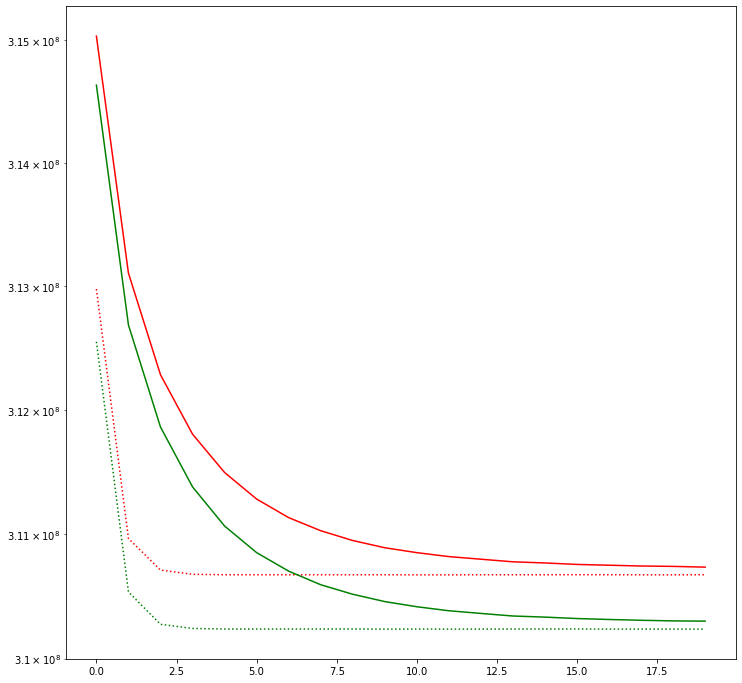

In [386]:
plt.semilogy(loss_rec1, 'r')
plt.semilogy(loss_ad_rec1, 'r', linestyle = 'dotted')
             
plt.semilogy(loss_rec2, 'g')
plt.semilogy(loss_ad_rec2, 'g', linestyle = 'dotted')

#### OASIS

In [57]:
5e-2

0.05

In [58]:
jnp.max(jnp.abs(v_rec1))/(1+N*1e-9)

DeviceArray(6688.37808493, dtype=float64)

In [59]:
N*1e-9

1e-05

In [411]:
N_epoch = 20 #30
beta2 =  0.9
eta0 = 10 # 1e0 #5e-2 #1e-2 # 1e-3 #1e-5 #0.0001 #0.1/0.001/0.01/0.15
batch_size = 1000
alpha = 0 #1e-7 

D0bad = jnp.array(np.random.randn(*D01.shape))



#### Tri interpolation, lam=1e-9

# 10k imgs, 64px:
#  1e-1 (*0.5 or not depending on beta2)

# 40k imgs, 128px:
#  1e-2 

# On the big dataset, D1 D2 as calculated for NN interpolation seem better than the ones obtained 
# using Hutchinson's method with 20 epochs.


#### NN interpolation, no sigma_noise, lam=1e-9

# 10k imgs, 64px:
#   1e-1

# 40k imgs, 128px:
#   1e-2

# 52k imgs, 192px: (lam=1e-7)
#   1e-2 

In [415]:
key, subkey = random.split(key)

t0 = time.time()

#v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x01, eta0, jnp.ones(D01.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, iter_display = 1)
v_rec_o1, loss_o1 = oasis(subkey, loss_func1, grad_func1, hvp_func1, x01, eta0, jnp.ones(D01.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, adaptive_step_size = True, iter_display = 1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/20


100%|██████████| 10/10 [00:05<00:00,  1.98it/s, loss=3.160e+08]


  Loss =  3.167e+08
  eta = 1.25
Epoch 2/20


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, loss=3.151e+08]


  Loss =  3.142e+08
  eta = 0.625
Epoch 3/20


100%|██████████| 10/10 [00:04<00:00,  2.06it/s, loss=3.114e+08]


  Loss =  3.130e+08
  eta = 0.3125
Epoch 4/20


100%|██████████| 10/10 [00:04<00:00,  2.05it/s, loss=3.118e+08]


  Loss =  3.122e+08
  eta = 0.15625
Epoch 5/20


100%|██████████| 10/10 [00:04<00:00,  2.05it/s, loss=3.104e+08]


  Loss =  3.116e+08
  eta = 0.078125
Epoch 6/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.117e+08]


  Loss =  3.111e+08
  eta = 0.078125
Epoch 7/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.096e+08]


  Loss =  3.108e+08
  eta = 0.078125
Epoch 8/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.139e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 9/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.108e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 10/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.085e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 11/20


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, loss=3.130e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 12/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.131e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 13/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.101e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 14/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.143e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 15/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.139e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 16/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.088e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 17/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.100e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 18/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.126e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 19/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.069e+08]


  Loss =  3.107e+08
  eta = 0.078125
Epoch 20/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.100e+08]


  Loss =  3.107e+08
  eta = 0.078125
Total time:  112.79 seconds


In [416]:
key, subkey = random.split(key)

t0 = time.time()

#v_rec_o2, loss_o2 = oasis(subkey, loss_func2, grad_func2, hvp_func2, x02, eta0, jnp.ones(D02.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, iter_display = 1)
v_rec_o2, loss_o2 = oasis(subkey, loss_func2, grad_func2, hvp_func2, x02, eta0, jnp.ones(D02.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, adaptive_step_size = True, iter_display = 1)

print(f"Total time: {time.time()-t0 : .2f} seconds")

Epoch 1/20


100%|██████████| 10/10 [00:04<00:00,  2.01it/s, loss=3.177e+08]


  Loss =  3.163e+08
  eta = 1.25
Epoch 2/20


100%|██████████| 10/10 [00:04<00:00,  2.07it/s, loss=3.157e+08]


  Loss =  3.138e+08
  eta = 0.625
Epoch 3/20


100%|██████████| 10/10 [00:04<00:00,  2.06it/s, loss=3.161e+08]


  Loss =  3.126e+08
  eta = 0.3125
Epoch 4/20


100%|██████████| 10/10 [00:04<00:00,  2.06it/s, loss=3.109e+08]


  Loss =  3.118e+08
  eta = 0.15625
Epoch 5/20


100%|██████████| 10/10 [00:04<00:00,  2.08it/s, loss=3.105e+08]


  Loss =  3.111e+08
  eta = 0.078125
Epoch 6/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.111e+08]


  Loss =  3.106e+08
  eta = 0.078125
Epoch 7/20


100%|██████████| 10/10 [00:04<00:00,  2.08it/s, loss=3.094e+08]


  Loss =  3.104e+08
  eta = 0.078125
Epoch 8/20


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, loss=3.093e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 9/20


100%|██████████| 10/10 [00:04<00:00,  2.08it/s, loss=3.102e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 10/20


100%|██████████| 10/10 [00:04<00:00,  2.11it/s, loss=3.085e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 11/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.101e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 12/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.101e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 13/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.105e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 14/20


100%|██████████| 10/10 [00:04<00:00,  2.09it/s, loss=3.081e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 15/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.104e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 16/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.101e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 17/20


100%|██████████| 10/10 [00:04<00:00,  2.13it/s, loss=3.067e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 18/20


100%|██████████| 10/10 [00:04<00:00,  2.10it/s, loss=3.090e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 19/20


100%|██████████| 10/10 [00:04<00:00,  2.12it/s, loss=3.075e+08]


  Loss =  3.102e+08
  eta = 0.078125
Epoch 20/20


100%|██████████| 10/10 [00:04<00:00,  2.13it/s, loss=3.101e+08]


  Loss =  3.102e+08
  eta = 0.078125
Total time:  112.84 seconds


In [417]:
key, subkey = random.split(key)

#v_rec_oa1, loss_oa1 = oasis_adaptive(subkey, loss_func1, grad_func1, hvp_func1, x0, eta0, jnp.ones(D01.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, iter_display = 1)


In [418]:
key, subkey = random.split(key)

#v_rec_oa2, loss_oa2 = oasis_adaptive(subkey, loss_func2, grad_func2, hvp_func2, x0, eta0, jnp.ones(D02.shape), beta2, alpha, N_epoch, batch_size = batch_size, N = N, iter_display = 1)


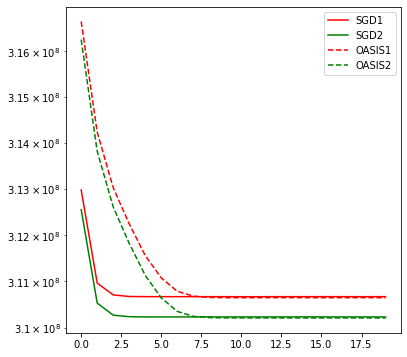

In [419]:
plt.semilogy(loss_ad_rec1, 'r')
plt.semilogy(loss_ad_rec2, 'g')
plt.semilogy(loss_o1, 'r--')
plt.semilogy(loss_o2, 'g--')
#plt.semilogy(loss_oa1)
#plt.semilogy(loss_oa2)
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "OASIS_a1", "OASIS_a2"])


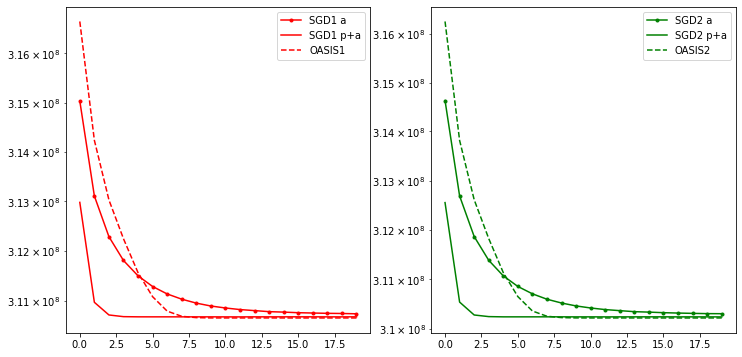

In [420]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(121)

plt.semilogy(loss_rec1, 'r.-')
plt.semilogy(loss_ad_rec1, 'r')
plt.semilogy(loss_o1, 'r--')

plt.legend(["SGD1 a", "SGD1 p+a", "OASIS1"])

plt.subplot(122)

plt.semilogy(loss_rec2, 'g.-')
plt.semilogy(loss_ad_rec2, 'g')
plt.semilogy(loss_o2, 'g--')

plt.legend(["SGD2 a", "SGD2 p+a", "OASIS2"])


plt.rcParams["figure.figsize"]=6, 6


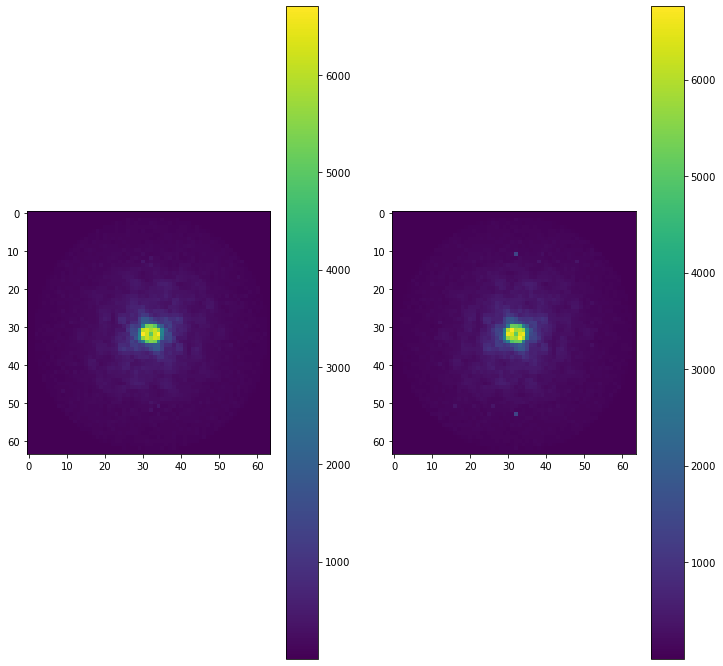

In [421]:
plt.rcParams["figure.figsize"]= 12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_o1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_o2))); plt.colorbar()


In [422]:
#plt.rcParams["figure.figsize"]= 12, 12

#plt.subplot(1,2,1)
#mip_z(np.fft.fftshift(np.real(v_rec_oa1))); plt.colorbar()

#plt.subplot(1,2,2)
#mip_z(np.fft.fftshift(np.abs(v_rec_oa2))); plt.colorbar()


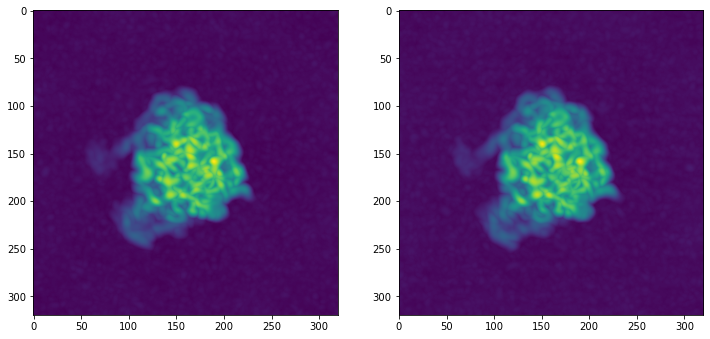

In [423]:
v_rec_ol1, _ = rescale_larger_grid(v_rec_o1, x_grid, nx0)
vr_o1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol1)))

v_rec_ol2, _ = rescale_larger_grid(v_rec_o2, x_grid, nx0)
vr_o2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_ol2)))

plt.subplot(1,2,1)
mip_z(vr_o1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_o2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [424]:
with mrcfile.new(f"{out_dir}/v_rec_o1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_o2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_o2.astype(np.float32))   

Text(0.5, 1.0, 'FSC')

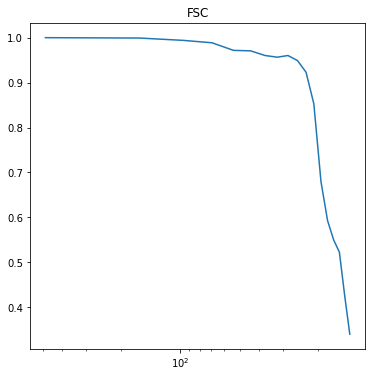

In [425]:
res, fsc_o, shell_points = calc_fsc(v_rec_o1, v_rec_o2, [1, nx_crop])
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_o)
plt.gca().invert_xaxis()
plt.title("FSC")

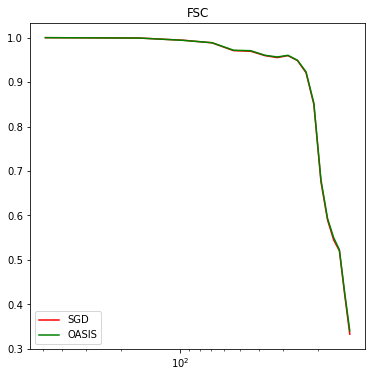

In [426]:
plt.semilogx(res_angs, fsc_sgd, 'r')
plt.semilogx(res_angs, fsc_o, 'g')
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

In [427]:
print(fsc_o[19])
print(fsc_o[20])
print(res_angs[19])
print(res_angs[20])

0.3400622234706747
0.3400622234706747
13.830013305388063
13.830013305388063


In [428]:
print(fsc_o[26])
print(fsc_o[27])
print(res_angs[26])
print(res_angs[27])

0.3400622234706747
0.3400622234706747
13.830013305388063
13.830013305388063


In [429]:
# Just make sure that the loss at the starting points x01 and x02 is indeed larger than
# everything plotted

batch_sz = 100
n_batch = N / batch_sz
idx_batches = np.array_split(np.arange(N), n_batch)

loss_x01 = 0
loss_x02 = 0
for idx in tqdm(idx_batches):
    loss_x01 += loss_func1(x01, idx)
    loss_x02 += loss_func2(x02, idx)
    
loss_x01 = loss_x01/n_batch                             
loss_x02 = loss_x02/n_batch 

print(f"loss1(x01) = {loss_x01}")
print(f"loss2(x02) = {loss_x02}")

100%|██████████| 100/100 [00:01<00:00, 53.12it/s]

loss1(x01) = 328675172.9729245
loss2(x02) = 328305841.73326087


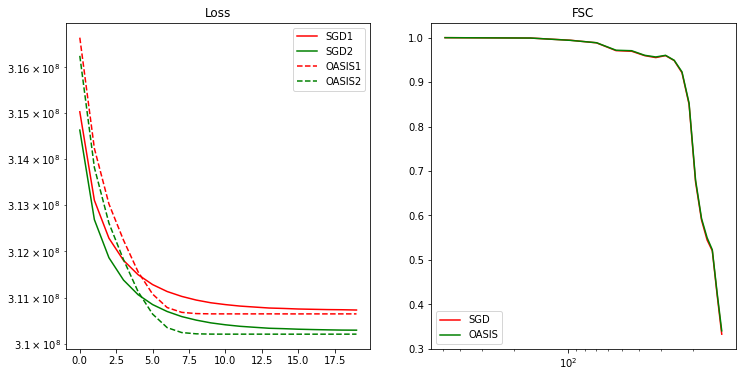

In [430]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.semilogy(loss_rec1, 'r')
plt.semilogy(loss_rec2, 'g')
plt.semilogy(loss_o1, 'r--')
plt.semilogy(loss_o2, 'g--')

#plt.semilogy(loss_x01 * np.ones((N_epochs,)))
#plt.semilogy(loss_x02 * np.ones((N_epochs,)))       

plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd, 'r')
plt.semilogx(res_angs, fsc_o, 'g')
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS"])

plt.rcParams["figure.figsize"]=6,6

#### CG

In [431]:
N_iter = 20


In [432]:
AA1, Ab1 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles1, shifts1, ctf_params1, imgs_f1, v_rec1.shape, sigma_noise)
AA2, Ab2 = get_cg_vol_ops(gradv_obj.grad_loss_volume_sum, angles2, shifts2, ctf_params2, imgs_f2, v_rec1.shape, sigma_noise)


In [433]:
v_rec_cg1, k1, v_rec_cg1_all = cg(AA1, Ab1, x01, N_iter, verbose=True)

  cg iter 0 ||r|| = 341.4758039848162
  cg iter 10 ||r|| = 19.491531668821406


In [434]:
v_rec_cg2, k2, v_rec_cg2_all = cg(AA2, Ab2, x02, N_iter, verbose=True)

  cg iter 0 ||r|| = 338.81293883118246
  cg iter 10 ||r|| = 18.73338376685502


In [435]:
loss_cg1 = jax.vmap(loss_func1, in_axes = (0, None))(jnp.array(v_rec_cg1_all), jnp.arange(N))
loss_cg2 = jax.vmap(loss_func2, in_axes = (0, None))(jnp.array(v_rec_cg2_all), jnp.arange(N))

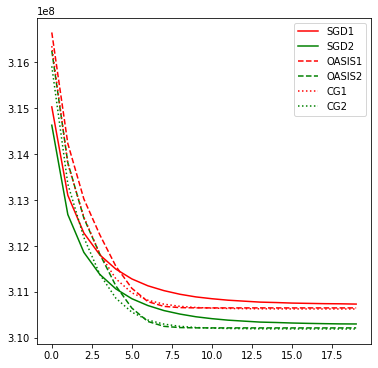

In [436]:
plt.plot(loss_rec1, 'r')
plt.plot(loss_rec2, 'g')
plt.plot(loss_o1, 'r--')
plt.plot(loss_o2, 'g--')
plt.plot(loss_cg1, 'r:')
plt.plot(loss_cg2, 'g:')

plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])


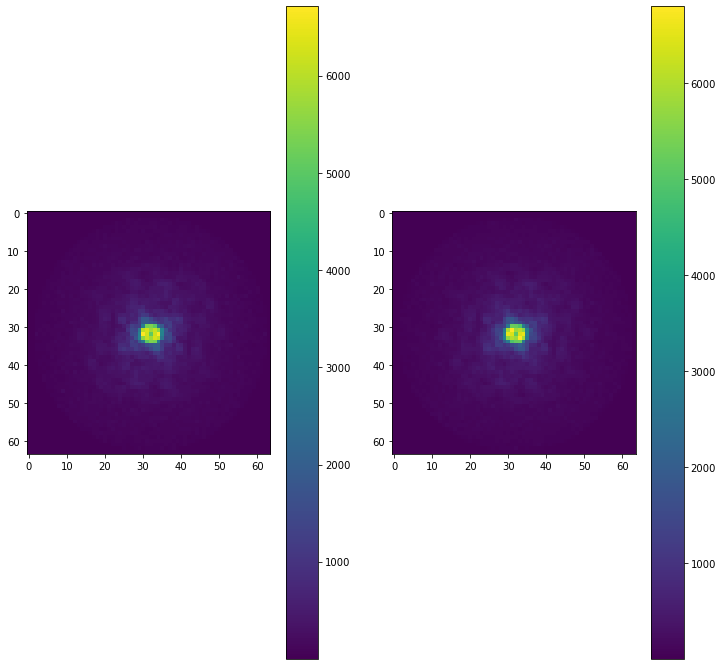

In [437]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec_cg1))); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec_cg2))); plt.colorbar()

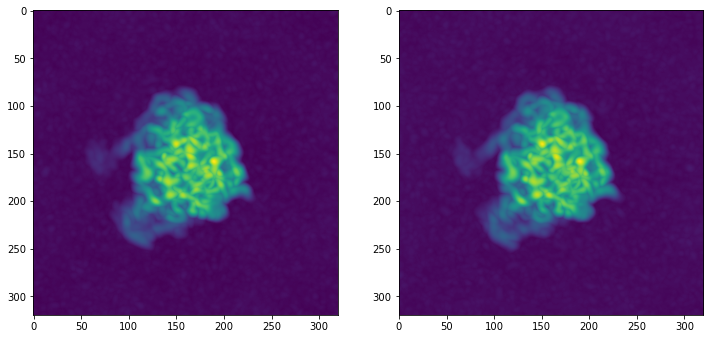

In [438]:
v_rec_cgl1, _ = rescale_larger_grid(v_rec_cg1, x_grid, nx0)
vr_cg1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl1)))

v_rec_cgl2, _ = rescale_larger_grid(v_rec_cg2, x_grid, nx0)
vr_cg2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_cgl2)))

plt.subplot(1,2,1)
mip_z(vr_cg1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_cg2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [439]:
with mrcfile.new(f"{out_dir}/v_rec_cg1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_cg2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_cg2.astype(np.float32))  

Text(0.5, 1.0, 'FSC')

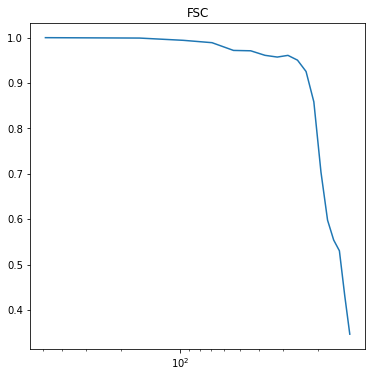

In [440]:
res, fsc_cg, shell_points = calc_fsc(v_rec_cg1, v_rec_cg2, [1, nx_crop])

res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")

In [441]:
fsc_cg

DeviceArray([1.        , 0.99912192, 0.99415563, 0.98894574, 0.97187549,
             0.97106009, 0.96106795, 0.95724302, 0.96095429, 0.95045193,
             0.92546273, 0.85850933, 0.70346152, 0.59767455, 0.5539119 ,
             0.53026701, 0.43127461, 0.34642225], dtype=float64)

In [442]:
loss1_x0 = loss_func1(x01, jnp.arange(N)) * jnp.ones((N_iter,))
loss2_x0 = loss_func2(x02, jnp.arange(N)) * jnp.ones((N_iter,))

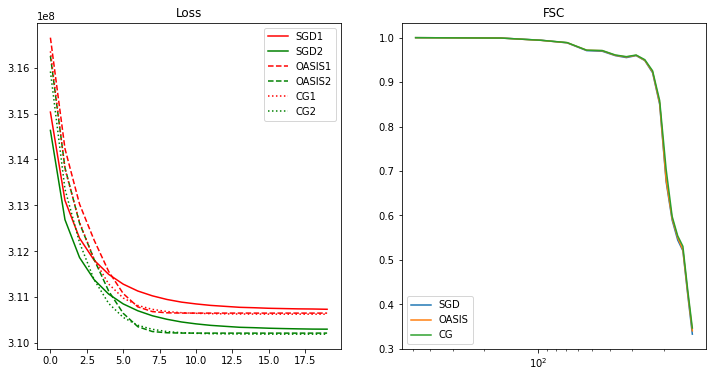

In [443]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)

plt.plot(loss_rec1, 'r')
plt.plot(loss_rec2, 'g')
plt.plot(loss_o1, 'r--')
plt.plot(loss_o2, 'g--')
plt.plot(loss_cg1, 'r:')
plt.plot(loss_cg2, 'g:')
#plt.semilogy(loss1_x0)
#plt.semilogy(loss2_x0)

plt.title("Loss")
plt.legend(["SGD1", "SGD2", "OASIS1", "OASIS2", "CG1", "CG2"])

plt.subplot(1,2,2)

plt.semilogx(res_angs, fsc_sgd)
plt.semilogx(res_angs, fsc_o)
plt.semilogx(res_angs, fsc_cg)
plt.gca().invert_xaxis()
plt.title("FSC")
plt.legend(["SGD", "OASIS", "CG"])

plt.rcParams["figure.figsize"]=6,6

In [444]:
print(fsc_cg[15])
print(fsc_cg[16])
print(res_angs[15])
print(res_angs[16])

0.5302670104921068
0.43127461302208314
15.614531151244588
14.668195929957037


In [445]:
print(loss_func1(v_rec1, jnp.arange(N)))
print(loss_func1(v_ad_rec1, jnp.arange(N)))
print(loss_func1(v_rec_o1, jnp.arange(N)))
print(loss_func1(v_rec_cg1, jnp.arange(N)))

310734014.1873969
310673293.72323143
310650724.2583543
310627282.3790959


In [446]:
print(loss_func2(v_rec2, jnp.arange(N)))
print(loss_func2(v_ad_rec2, jnp.arange(N)))
print(loss_func2(v_rec_o2, jnp.arange(N)))
print(loss_func2(v_rec_cg2, jnp.arange(N)))

310300642.7469178
310236123.16098833
310215200.3187035
310191541.76596653


### Notes:

* It's important to use a large batch size for both SGD and OASIS: 1000 for 64-128px is good.
* OASIS rec with fixed rate is the same as SGD with D0 preconditioner,  the loss and results/FSC are almost identical (since here the Hessian doesn't depend on the current iterate and therefore is estimated perfectly at the beginning). -- actually not true in my latest experiments and I don't know why
* When using no $\sigma_{noise}$ with $128$ pixels and 40,000 images, both OASIS and SGD with precon required higher regularization parameter $10^{-5}$ compared to the other runs, where I used reg param $10^{-9}$
* I should with a dataset with no heterogeneity in the future
* Still don't know why the adaptive version fails

In [ ]:
pixel_size * 320/128

### Results:

Showing resolution cutoff at $FSC=0.5$ everywhere:

#### 1. Small data: `nx_crop=64px` and 10,000 images in each half set, 20 epochs (for SGD/OASIS) and 20 iters (for CG):

Everything here is with regularization parameter $10^{-9}$

Trilinear interpolation
* SGD no precon: $\approx 20 Å$ 
* SGD with precon: $\approx 20 Å$ 
* OASIS: $\approx 20 Å$ 
* OASIS adaptive: meh
* CG: $\approx 20 Å$ 

Nearest neighbour interpolation:

All $\approx 20 Å$ 


^ The FSC curves are almost identical for all

#### 2. Large data: `nx_crop=128px` and 40,000 images in each half set, 10 epochs:

Tri and NN, all around $\approx 14-15 Å$ 

# Figuring out the algorithm, running it on toy problem

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [ ]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n), dtype=jnp.complex128)
A = A.T + A

plt.imshow(jnp.real(A)); plt.colorbar()

In [ ]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [ ]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [ ]:
d = np.zeros((iters, n), dtype=A.dtype)
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [ ]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

In [ ]:
plt.semilogy(jnp.abs(err))

#### Hessian-vector product in JaX

In [ ]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [ ]:
b = A @ x0 
f = lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A@x-b)))

In [ ]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [ ]:
%timeit hvp0(f, x, v)

%timeit hvp(f, (x,), (v,))

v1 = hvp0(f, x, v)
v2 = hvp(f, (x,), (v,))
jnp.sum(jnp.abs(v1-v2))

#### Toy problem

In [ ]:
key, *subkey = random.split(key, 3)

x_gt = random.normal(subkey[0], (n,), dtype=jnp.complex128)

A = random.normal(subkey[1], (n,n), dtype=x_gt.dtype)
A = A.T @ A
_, v = jnp.linalg.eigh(A)
d = jnp.flip(jnp.logspace(-5,1,n)) 
d = d + jnp.abs(jnp.min(d)*2)
A = v.T @ jnp.diag(d) @ v

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort(evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.imag(evals)) < 1e-13)
#assert(jnp.max(jnp.abs(A.T - A)) == 0)
#assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)

evals = jnp.real(evals)
plt.semilogy(evals, '.')
plt.title("Eigenvalues")
print(f"Condition number = {evals[0]/evals[n-1] : .2e}")

In [ ]:
sig_noise = 1
lam = 0.1

key, subkey = random.split(key)

b = A @ x_gt  + random.normal(subkey, (n,)) * sig_noise

F = jax.jit(lambda x : jnp.real(jnp.mean(jnp.conj(A @ x - b)*(A @ x - b)) + lam * jnp.mean(jnp.conj(x)*x)))
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.jit(jax.grad(F))
#hessianF = jax.hessian(F)

hvpF = jax.jit(lambda x, v : hvp(F, (x,), (v,)))

print(f"gradF(x_gt) = {gradF(x_gt)}")
#print(f"hessianF(x_gt) = {hessianF(x_gt)}")


In [ ]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * jnp.conj(gradF(w0))
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.conj(jnp.linalg.inv(H) @ G)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [ ]:
N_iter = 1000
eta = 1e-3 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

In [ ]:
plt.semilogy(loss_gd)

In [ ]:
#N_iter = 10

#x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

In [ ]:
#plt.plot(loss_n)

In [ ]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = jax.jit(lambda vv : jnp.conj(gradF(vv)) + Ab)

x_cg, kk, x_cg_all = cg(AA, Ab, x0, N_iter, verbose=True)
loss_cg = jax.vmap(F)(jnp.array(x_cg_all))

In [ ]:
print(F(x_gt))
print(F(x_cg))
print(F(x_gd))
#print(F(x_n))

#### OASIS

In [ ]:
Fidx = jax.jit(lambda x, idx : F(x))
gradFidx = jax.jit(lambda x, idx : jax.grad(F)(x))
hvpFidx = jax.jit(lambda x, v, idx : hvp(F, (x,), (v,)))

In [ ]:
# Estimating D0

iters = 100000
key, *subkeys = random.split(key, iters+1)
zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[i], (n,), dtype=x0.dtype)
    
    zD0z += z * hvpFidx(x0, z, 1)
    
D0 = jnp.array(zD0z/iters)

#D0exact = jnp.diag(hessianF(x0)) # Cheating a bit


In [ ]:
#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_iter = 1000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)


In [ ]:
N_iter = 1000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 500)


In [ ]:
#print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)

nn0 = 0
nn1 = 1000
#plt.semilogy(loss_n[nn0:nn1])
plt.semilogy(loss_gd[nn0:nn1])
plt.semilogy(loss_cg[nn0:nn1])
plt.semilogy(loss_o[nn0:nn1])
plt.semilogy(loss_oa[nn0:nn1])
#plt.legend(["Newton", "GD", "OASIS", "OASIS adaptive"])
plt.legend(["GD", "CG", "OASIS", "OASIS adaptive"])
plt.title("Loss")

plt.subplot(1,2,2)
#plt.semilogy(jnp.abs(x_gt-x_n))
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_o))
plt.semilogy(jnp.abs(x_gt-x_oa))
plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6, 6

### Stochastic - sum of operators

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

Generate $N$ operators to create a loss function to run SGD/OASIS on:

In [ ]:
sig_noise = 10
lam = 0.1

In [ ]:
n = 100
N = 1000

key, subkey = random.split(key)

x_gt = random.normal(subkey, (n,), dtype=jnp.complex128)

ops = []
b = []
for i in range(N):
    key, *subkeys = random.split(key, 4)
    
    A = random.normal(subkeys[0], (n,n), dtype = x_gt.dtype)
    A = A.T @ A
    _, v = jnp.linalg.eigh(A)
    
    d = jnp.logspace(10,-5,n) + random.normal(subkeys[1], (n,), dtype = jnp.double)*10 
    d = d + jnp.abs(jnp.min(d)*2)
                 
    A = v.T @ jnp.diag(d) @ v
    ops.append(A)
    
    bn = A @ x_gt + random.normal(subkeys[2], (n,), dtype = x_gt.dtype) * sig_noise
    b.append(bn)
    
    #print(jnp.mean((A@x_gt - bn)**2))
    
ops = jnp.array(ops)
b = jnp.array(b)

In [ ]:
w, _ = jnp.linalg.eigh(A)
w = jnp.flip(jnp.sort(w))
print(f"{jnp.max(w)/jnp.min(w) : .2e}")

In [ ]:
print(jnp.max(w))
print(jnp.min(w))

In [ ]:
def loss_term(x, A, b):
    return 1/2 * jnp.real(jnp.mean(jnp.conj(A@x - b)*(A@x - b)) + lam * jnp.mean(jnp.conj(x)*x))

def loss_func(x, ops, b):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0))(x, ops, b))

def grad_loss_func(x, ops, b):
    return jax.grad(loss_func)(x, ops, b)

def hvp_loss_func(x, v, ops, b):
    return jvp(lambda y : grad_loss_func(y, ops, b), (x,), (v,))[1]

In [ ]:
idx = np.random.permutation(N)[:N//3]

print(loss_term(x_gt, ops[0], b[0]))
print(loss_func(x_gt, ops, b))

print(grad_loss_func(x_gt, ops, b).shape)
print(grad_loss_func(x_gt, ops[idx], b[idx]).shape)

print(hvp_loss_func(x_gt, x_gt, ops, b).shape)
print(hvp_loss_func(x_gt, x_gt, ops[idx], b[idx]).shape)

In [ ]:
key, subkey = random.split(key)

hessianF = lambda x : jax.hessian(loss_func)(x, ops, b)

Fidx = jax.jit(lambda x, idx : loss_func(x, ops[idx], b[idx]))
gradFidx = jax.jit(lambda x, idx : grad_loss_func(x, ops[idx], b[idx]))
hvpFidx = jax.jit(lambda x, v, idx : hvp_loss_func(x, v, ops[idx], b[idx]))
x0 = random.normal(subkey, (n,), dtype = x_gt.dtype)

In [ ]:
Fidx(x_gt, jnp.arange(N))

In [ ]:
#D0 = jnp.ones((nx,nx,nx))  #<--- not very good
#D0exact = jnp.diag(hessianF(x0)) # This is cheating

iters = 10000
batch_sz = 32
key, *subkeys = random.split(key, 2*iters+1)

zD0z = np.zeros((n,))

for i in tqdm(range(iters)):
    z = random.rademacher(subkeys[2*i], (n,), dtype=x0.dtype)
    idx = random.permutation(subkeys[2*i+1], N)[:batch_sz]
    
    zD0z += z * hvpFidx(x0, z, idx)
    
D0 = jnp.array(zD0z/iters)


#plt.plot(jnp.abs(D0-D0exact)/jnp.abs(D0exact))

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_os, loss_os = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 0.01 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_osa, loss_osa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = 20, N = N, iter_display = 1)


In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1 #0.1 #0.1/0.001/0.01/0.15
                       
alpha = 0 #0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, Fidx, gradFidx, hvpFidx, x0, eta, D0, beta2, alpha, N_epoch, batch_size = None, N=N, iter_display = 1)


In [ ]:
N_epoch = 20
eta = 1e-18
                       
key, subkey = random.split(key)
x_sgd, loss_sgd, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, verbose = True, iter_display = 1)

In [ ]:
N_epoch = 20
beta2 = 0.99
eta = 1e-1
                       
key, subkey = random.split(key)
x_sgdp, loss_sgdp, _ = sgd(gradFidx, Fidx, N, x0, eta, N_epoch, batch_size = 20, P = 1/D0, verbose = True, iter_display = 1)

In [ ]:
plt.rcParams["figure.figsize"]=12, 6

plt.subplot(1,2,1)
plt.semilogy(loss_sgd)
plt.semilogy(loss_sgdp)
plt.semilogy(loss_o)
plt.semilogy(loss_os)
plt.semilogy(loss_oa)
plt.semilogy(loss_osa)
plt.legend(["SGD", "SGD precon", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
#plt.legend(["SGD", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.semilogy(jnp.abs(x_sgd-x_gt))
plt.semilogy(jnp.abs(x_sgdp-x_gt))
#plt.semilogy(jnp.abs(x_o-x_gt))
plt.semilogy(jnp.abs(x_os-x_gt))
#plt.semilogy(jnp.abs(x_oa-x_gt))
plt.semilogy(jnp.abs(x_osa-x_gt))
#plt.legend(["SGD", "OASIS fixed rate, deterministic", "OASIS fixed_rate, stochastic", "OASIS adaptive, deterministic", "OASIS adaptive, stochastic"])
plt.legend(["SGD", "SGD+p", "OASIS fixed_rate, stochastic", "OASIS adaptive, stochastic"])
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

In [ ]:
plt.semilogy(loss_sgdp)
plt.semilogy(loss_os)
plt.legend(["Loss SGD+precon", "Loss OASIS stochastic"])

In [ ]:
print(Fidx(x_gt, jnp.arange(N)))
print(Fidx(x_sgd, jnp.arange(N)))
print(Fidx(x_sgdp, jnp.arange(N)))
print(Fidx(x_o, jnp.arange(N)))
print(Fidx(x_os, jnp.arange(N)))
print(Fidx(x_oa, jnp.arange(N)))
print(Fidx(x_osa, jnp.arange(N)))


Next:

* ~~Run the new OASIS algorithms on the old (deterministic one operator) toy problem~~
* ~~Implement the adaptive version of the stochastic OASIS~~
* ~~Add noise and rerun all the experiments~~
* In the stochastic toy problem case, also compare with CG (make the problem small enough so that we can do CG)
* ~~Implement some kind of warm up /estimation of $D_0$~~
* ~~Run on CryoEM data~~